## 1. Import required Libraries

In [ ]:
# <<insert yout code here>>
import os 
import numpy as np
import tensorflow as tf

from collections import Counter
from sklearn.model_selection import KFold, train_test_split
from cleanlab.filter import find_label_issues
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

## 2. Loading the Data

In [ ]:
# <<insert yout code here>>
image_dir = './Images'

labels = []
data = []

allowed_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
img_size = (150, 150)   

for label in os.listdir(image_dir):
    subfolder_path = os.path.join(image_dir, label)

    if os.path.isdir(subfolder_path):
        for image_file in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, image_file)

            if any(image_file.lower().endswith(ext) for ext in allowed_extensions):
                try: 
                    image = tf.keras.preprocessing.image.load_img(image_path, color_mode='rgb', target_size=img_size)
                    image = np.array(image)

                    labels.append(int(label[-1]) -1)
                    data.append(image)
                
                except Exception as e:
                    print(f"Error loading image {image_path}: {e}")


X_all = np.array(data)
y_all = np.array(labels)


print("Loaded images:", X_all.shape)
print("Loaded labels:", y_all.shape)
print("First 5 images in X_all:\n", X_all[:5])
print("First 5 labels in y_all:\n", y_all[:5])

Loaded images: (8538, 150, 150, 3)
Loaded labels: (8538,)


## 3. Data Labelling Errors

In [5]:
# <<insert yout code here>>
# Temp model for cleanlab
def temp_model(num_classes):
    base_model = tf.keras.applications.MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
    
    # unfreezes the last 30 layers so they can learn
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False
        
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=outputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



In [6]:
# cross validation
num_classes = len(np.unique(y_all))

pred_probs = np.zeros((len(X_all), num_classes))
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
accuracies = []

for train_idx, val_idx in kf.split(X_all):
    model = temp_model(num_classes)
    history = model.fit(
        X_all[train_idx],
        y_all[train_idx],
        epochs=5,
        batch_size=16, 
        verbose=1 
    )

    val_loss, val_acc = model.evaluate(X_all[val_idx], y_all[val_idx], verbose=0)
    accuracies.append(val_acc)
    print(f"Fold {fold}/5 - Val Accuracy: {val_acc:.2%}")

    pred_probs[val_idx] = model.predict(X_all[val_idx], verbose=0)
    fold += 1

avg_acc = np.mean(accuracies)
print(f"\nAverage Model Accuracy: {avg_acc:.2%}")
print("Cross-validation complete!")


Epoch 1/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.4038 - loss: 1.6112
Epoch 2/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.7006 - loss: 0.8903
Epoch 3/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - accuracy: 0.8397 - loss: 0.4895
Epoch 4/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.9242 - loss: 0.2661
Epoch 5/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - accuracy: 0.9529 - loss: 0.1628
Fold 1/5 - Val Accuracy: 61.07%
Epoch 1/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - accuracy: 0.3984 - loss: 1.6214
Epoch 2/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 27s 63ms/step - accuracy: 0.6843 - loss: 0.9038
Epoch 3/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 27s 64ms/step - accuracy: 0.8407 - loss: 0.5006
Epoch 4/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 27s 62ms/step - accuracy: 0.9171 - loss: 0.2751
Epoch 5/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 28s 66ms/step - accuracy: 0.9531 - loss: 0.1696
Fold 2/5 - Val Accuracy: 62.06%
Epoch 1/5
427/427 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - accuracy: 0

In [7]:
# Identify label issues using Cleanlab
label_issues = find_label_issues(
    labels=y_all,
    pred_probs=pred_probs,
    return_indices_ranked_by='self_confidence'
)

print("Number of suspected label errors:", len(label_issues))
label_issues[:20]


Number of suspected label errors: 2464


array([2397,  640, 4390,  268,  689, 5335, 4318, 3429, 2520, 5723, 1723,
       7336, 1321, 7029, 2511, 1930, 1062, 1722, 4310,  688])

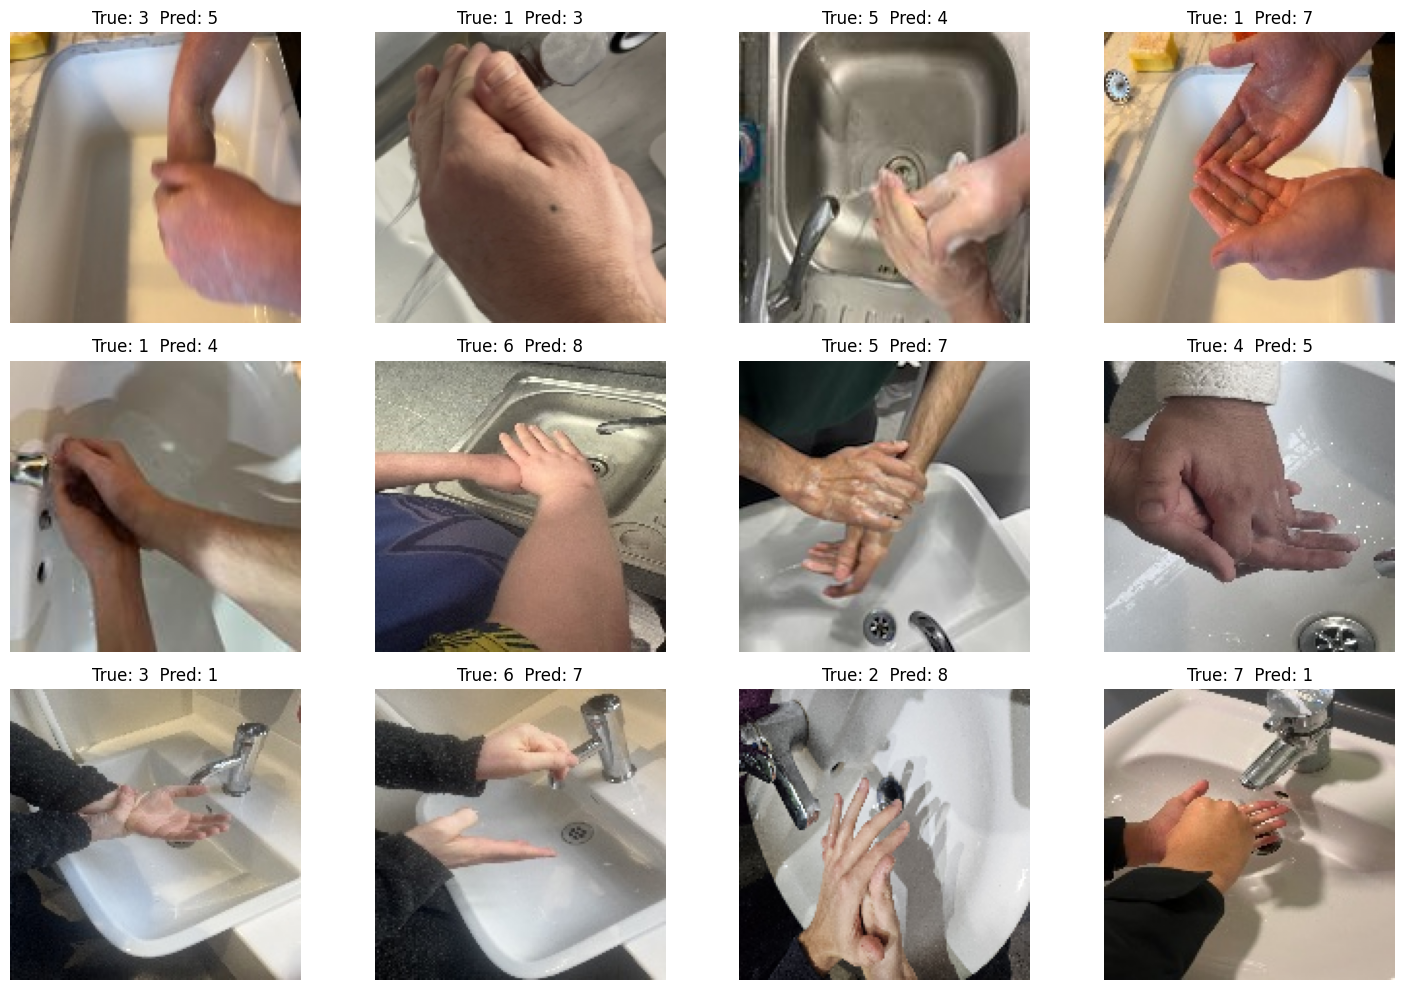

In [8]:
def show_issues(indices, n=12):
    plt.figure(figsize=(15,10))
    for i, idx in enumerate(indices[:n]):
        plt.subplot(3,4,i+1)
        plt.imshow(X_all[idx])
        plt.axis('off')

        true_lbl = y_all[idx] + 1
        pred_lbl = np.argmax(pred_probs[idx]) + 1

        plt.title(f"True: {true_lbl}  Pred: {pred_lbl}")

    plt.tight_layout()
    plt.show()

show_issues(label_issues)


In [9]:
# Deleting the skewed images
X_clean = np.delete(X_all, label_issues, axis=0)
y_clean = np.delete(y_all, label_issues, axis=0)

print(f"Original size: {len(X_all)}")
print(f"New size: {len(X_clean)}")

Original size: 8538
New size: 6074


In [10]:
# count samples per class
class_counts = Counter(y_clean)

for cls in sorted(class_counts.keys()):
    print(f"Stage {cls+1}: {class_counts[cls]}")


Stage 1: 932
Stage 2: 561
Stage 3: 636
Stage 4: 792
Stage 5: 764
Stage 6: 687
Stage 7: 839
Stage 8: 863


## Label errors:


<ol>
  <li>The method used</li>
  For identifying label issues, I used Cleanlab’s self-confidence method. Cleanlab works by comparing the model’s predicted probabilities with the provided labels and highlighting the images the model is least confident about.

  I tried several different modelling approaches, including both traditional ML and neural networks, and the highest accuracy I could achieve was around 62%. This suggested that the main problem wasn’t the choice of model but the data itself, many images are difficult to distinguish, even for a trained model. Because of this, instead of relying on Cleanlab to identify exact label mistakes, which requires a highly accurate model, I used it to detect ambiguous or unclear images. These are the samples the model consistently struggled with, and removing them helps improve overall data quality.

  <li>Explain what kind of errors you found in the dataset.</li>
  When I reviewed the top 20 lowest-confidence images, there was a mix of issues. Some genuinely had incorrect labels, but many were correctly labelled and the model’s prediction was wrong. This happened because the model’s accuracy was relatively low, so the probability scores Cleanlab relied on weren’t strong enough to clearly separate “bad labels” from “bad predictions.”

  A lot of these images were also simply unclear or ambiguous, similar stages, awkward angles, or low-quality samples that would confuse both the model and a human. So overall, the errors were a blend of real label mistakes and images the model couldn’t confidently classify, mainly due to the dataset’s ambiguity rather than the model itself.
  
  <li>List the total number of images left in each class/stage after the label error handling</li>
</ol>

<br>

<ol>
  <li>Stage 1: <887></li>
  <li>Stage 2: <587></li>
  <li>Stage 3: <683></li>
  <li>Stage 4: <785></li>
  <li>Stage 5: <680></li>
  <li>Stage 6: <770></li>
  <li>Stage 7: <762></li>
  <li>Stage 8: <889></li>
</ol>

## 4. Pre-process the Dataset

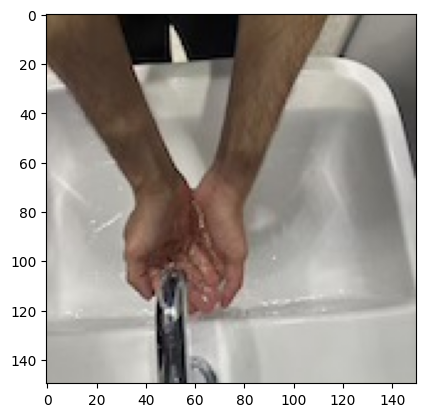

In [ ]:
# <<insert yout code here>>
# normalise the pixel values
X_clean = X_clean.astype('float32') / 255.0
print(f"X_clean.shape: {X_clean.shape}, y_clean.shape: {y_clean.shape}")
print("Normalised data:", X_clean[0])

## 5. Split the data
<br>

Split the data into training, validation and testing dataset using Startification, ensuring equal class distribution

Choose appropriate values of training, validation and testing datasets.

Display total number of images in each dataset split.

In [ ]:
# <<insert yout code here>>
X_train, X_temp, y_train, y_temp = train_test_split(
    X_clean, y_clean, test_size=0.30, random_state=42, stratify=y_clean
)

# Split 2: validation (15%) and test (15%) from the remaining 30%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


In [ ]:
# Data augmentation
train_aug = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

val_aug = ImageDataGenerator()  # No augmentation for val/test


## Data Preprocessing


## 6. Model Implementation

In [13]:
# <<insert yout code here>>

## 7. Evaluate the Model

In [14]:
# <<insert yout code here>>

### Training Curves

In [15]:
# <<insert yout code here>>

### Make Inference
For some unseen data, make predictions using the trained model.

In [16]:
# <<insert yout code here>>